In [1]:
import os

network_path = os.path.join("networks", "slice_example")
mesh_file = os.path.join(network_path, "mesh", "slice.obj")

if not os.path.exists(os.path.dirname(mesh_file)):
    os.makedirs(os.path.dirname(mesh_file))
    

Create a custom slice that is 1000x1000x25 micrometers in size.

In [2]:
from snudda.create_slice_mesh import create_slice_mesh
create_slice_mesh(file_name=mesh_file,
                  centre_point=[0.0, 0.0, 0.0],
                  x_len=1e-3,
                  y_len=1e-3,
                  z_len=25e-6,
                  description="This is a test slice corresponding to Allen Institute data")

Creating slice mesh
File: networks/slice_example/mesh/slice.obj
Centre: [0. 0. 0.]
Sides: 0.001 x 0.001 x 2.5e-05
Description: This is a test slice for Alex


Here we populate the slice with dSPN and iSPN neurons.

First we ```define_structure```, specifying ```struct_name``` and the ```struct_mesh``` which is a [wavefront obj file](https://en.wikipedia.org/wiki/Wavefront_.obj_file). The ```d_min``` parameter (SI units, so meters) specify how close neurons can be placed. The ```mesh_bin_width``` is voxelisation of the mesh, and it needs to be larger than 2*```d_min```.

Next we ```add_neurons```, passing ```name``` of the neuron, ```volume_id``` it belongs to, and the ```neuron_dir``` where the neurons are located. Note that each dSPN neuron morphology has its own folder, so point to the parent folder e.g. data/neurons/dspn.

The next step is ```add_neuron_target``` which specifies how neurons are coupled together. The connection is from ```neuron_name``` to ```target_name``` of type ```connection_type``` (here GABA). 

The ```dist_pruning``` is optional, and allows us to form preferentially proximal or distal synapses. In this example ```"1-np.exp(-(0.4*d/60e-6)**2)"``` will result in distal synapses (```d``` is the dendritic distance from the soma). We also specify the pruning parameters ```f1``` (probability of keeping a synapse), ```soft_max``` (a soft upper limit on the number of synapses between connected pairs), ```mu2``` (a soft lower limit on the number of synapses between connected pairs) and ```a3``` (fraction of all connected pairs that we keep, this is useful for changing connection probability without affecting the number of synapses between connected pairs).

The ```conductance``` has two values, the mean and standard deviation. The ```parameter_file``` specifies parameters for the synapse which is moddeled by ```mod_file```. You can also specify additional synapse parameters using the ```channel_param_dictionary```.

Finally we need to write the config file.

In [3]:
from snudda.init import SnuddaInit

cnc = SnuddaInit(network_path=network_path)

# d_min normally 15e-6, here set to 12e-6 because slice is only 25 micrometers, 2*d_min < mesh_bin_width
cnc.define_structure(struct_name="SliceExample", struct_mesh=mesh_file, d_min=12e-6, mesh_bin_width=25e-6)
cnc.add_neurons(name="dSPN", num_neurons=1000, volume_id="SliceExample",
                neuron_dir=os.path.join(cnc.data_path,"neurons","striatum","dspn"))
cnc.add_neurons(name="iSPN", num_neurons=1000, volume_id="SliceExample",
                neuron_dir=os.path.join(cnc.data_path,"neurons","striatum","ispn"))

SPN2SPNdistDepPruning = "1-np.exp(-(0.4*d/60e-6)**2)"

MSD1gGABA = [0.24e-9, 0.1e-9]
MSD2gGABA = [0.24e-9, 0.1e-9]

MSD1GABAfailRate = 0.7  # Taverna 2008, figure 2
MSD2GABAfailRate = 0.4  # Taverna 2008, 2mM

pfdSPNdSPN = os.path.join(cnc.data_path, "synapses", "striatum", "PlanertFitting-DD-tmgaba-fit.json")
pfdSPNiSPN = os.path.join(cnc.data_path, "synapses", "striatum", "PlanertFitting-DI-tmgaba-fit.json")
pfiSPNdSPN = os.path.join(cnc.data_path, "synapses", "striatum", "PlanertFitting-ID-tmgaba-fit.json")
pfiSPNiSPN = os.path.join(cnc.data_path, "synapses", "striatum", "PlanertFitting-II-tmgaba-fit.json")

cnc.add_neuron_target(neuron_name="dSPN",
                       target_name="dSPN",
                       connection_type="GABA",
                       dist_pruning=SPN2SPNdistDepPruning,
                       f1=0.38, soft_max=3, mu2=2.4,
                       a3=1.0,
                       conductance=MSD1gGABA,
                       parameter_file=pfdSPNdSPN,
                       mod_file="tmGabaA",
                       channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                                 "tau2": (12.4e-3, 1e3),
                                                 "failRate": MSD1GABAfailRate})


cnc.add_neuron_target(neuron_name="dSPN",
                       target_name="iSPN",
                       connection_type="GABA",
                       dist_pruning=SPN2SPNdistDepPruning,
                       f1=0.20, soft_max=3, mu2=2.4,
                       a3=1.0,
                       conductance=MSD1gGABA,
                       parameter_file=pfdSPNiSPN,
                       mod_file="tmGabaA",
                       channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                                 "tau2": (12.4e-3, 1e3),
                                                 "failRate": MSD1GABAfailRate})


cnc.add_neuron_target(neuron_name="iSPN",
                       target_name="dSPN",
                       connection_type="GABA",
                       dist_pruning=SPN2SPNdistDepPruning,
                       f1=0.3, soft_max=4, mu2=2.4,
                       a3=1.0,
                       conductance=MSD2gGABA,
                       parameter_file=pfiSPNdSPN,
                       mod_file="tmGabaA",
                       channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                                 "tau2": (12.4e-3, 1e3),
                                                 "failRate": MSD2GABAfailRate})

cnc.add_neuron_target(neuron_name="iSPN",
                       target_name="iSPN",
                       connection_type="GABA",
                       dist_pruning=SPN2SPNdistDepPruning,
                       f1=0.55, soft_max=4, mu2=2.4,
                       a3=1.0,
                       conductance=MSD2gGABA,
                       parameter_file=pfiSPNiSPN,
                       mod_file="tmGabaA",
                       channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                                 "tau2": (12.4e-3, 1e3),
                                                 "failRate": MSD2GABAfailRate})

cnc.write_json()

CreateConfig
Seeding with rand_seed=None
Random seed init to 1086998677
Random seed place to 2061497739
Random seed detect to 1722284221
Random seed prune to 335354304
Random seed input to 2523075772
Random seed simulate to 1778258170
No structDef defined, not writing JSON file in init
Adding neurons: dSPN from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn
Adding neurons: iSPN from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn
Writing networks/slice_example/network-config.json


In [4]:
from snudda.place import SnuddaPlace
sp = SnuddaPlace(network_path=network_path)
sp.read_config()
sp.write_data()

Using hdf5 version: latest
Parsing configuration file networks/slice_example/network-config.json
Reading random see from config file: 2061497739
Using mesh_bin_width 2.5e-05
Found old cache file (networks/slice_example/mesh/slice.obj-25-cache.pickle), ignoring.
Running in serial
Voxel mask: 44x44x5
Processing x = 0
Processing x = 1
Processing x = 2
Processing x = 3
Processing x = 4
Processing x = 5
Processing x = 6
Processing x = 7
Processing x = 8
Processing x = 9
Processing x = 10
Processing x = 11
Processing x = 12
Processing x = 13
Processing x = 14
Processing x = 15
Processing x = 16
Processing x = 17
Processing x = 18
Processing x = 19
Processing x = 20
Processing x = 21
Processing x = 22
Processing x = 23
Processing x = 24
Processing x = 25
Processing x = 26
Processing x = 27
Processing x = 28
Processing x = 29
Processing x = 30
Processing x = 31
Processing x = 32
Processing x = 33
Processing x = 34
Processing x = 35
Processing x = 36
Processing x = 37
Processing x = 38
Processi

This plots the network, here we leave out axons and dendrites in the figure. Note that matplotlib will distort the axis in 3D plots, causing somas to not appear as spheres.

Loading networks/slice_example/network-neuron-positions.hdf5
No SlurmID set, using -1
Load done. 0.01786840899148956
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c10_D1-mWT-P270-20-v20190521/WT-P270-20-15ak-cor-cache.pickle
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn/str-ispn-e150908_c4_D2-m51-5-DE-v20190611/51-5-DE-cor-rep-ax-cache.pickle
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150602_c1_D1-mWT-0728MSN01-v20190508/WT-0728MSN01-cor-rep-ax-cache.pickle
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c6_D1-m21-6-DE-v20190503/21-6-DE-cor-rep-ax-cache.pickle
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c9_d1-mWT-1215MSN03-v20190521/WT-1215MSN03-cor-rep-ax2-cache.pickle
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn/str-ispn-e160118_c10_D2-m46-3-D

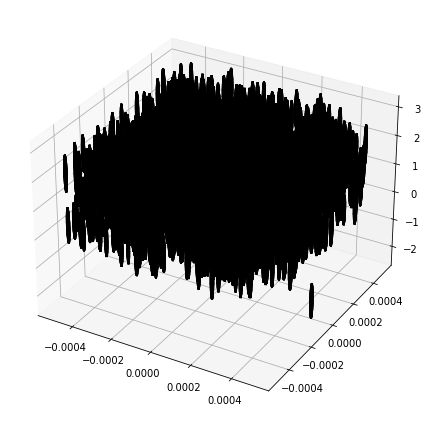

In [5]:
from snudda.plotting.plot_network import PlotNetwork
network_file = os.path.join(network_path, "network-neuron-positions.hdf5")
pn = PlotNetwork(network_file)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)
pn.close() 

For completion, let us do detection and pruning also. Note that we have chosen to specify ```hyper_voxel_size``` in this example, default value is 100. Larger values will take more memory but should be a bit faster, especially if running in serial mode. If your computer runs out of memory, reduce the ```hyper_voxel_size```.

In [6]:
from snudda.detect import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, hyper_voxel_size=250)
sd.detect()

Creating directory networks/slice_example/log
Using hdf5 driver version: latest
Memory: 62194225152 free, 67218092032 total
Each hyper voxel has 100 x 100 x 100 voxels
Touch detecting all volumes
Loading from networks/slice_example/network-config.json
Reading random seed from config file: 1722284221
Reading prototype for: dSPN_0
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c6_D1-m21-6-DE-v20190503/21-6-DE-cor-rep-ax-cache.pickle
Reading prototype for: dSPN_1
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c10_D1-mWT-P270-20-v20190521/WT-P270-20-15ak-cor-cache.pickle
Reading prototype for: dSPN_2
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c9_d1-mWT-1215MSN03-v20190521/WT-1215MSN03-cor-rep-ax2-cache.pickle
Reading prototype for: dSPN_3
Found cache file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150602_c1_D1-mWT-0728MSN01-

Create lookup table
detectSynapses: 3655 took 0.07212684798287228 s
detect_gap_junctions: No gap junctions defined in connectivity rules
Wrote hyper voxel 36 (3655 synapses, 0 gap junctions)
HyperID 36 completed - 3655  synapses and 0 gap junctions found (in 76.49339816503925 s)
Processing hyper voxel : 60/196(354 neurons)
Create lookup table
detectSynapses: 3078 took 0.062456480984110385 s
detect_gap_junctions: No gap junctions defined in connectivity rules
Wrote hyper voxel 60 (3078 synapses, 0 gap junctions)
HyperID 60 completed - 3078  synapses and 0 gap junctions found (in 69.60498181503499 s)
Processing hyper voxel : 88/196(352 neurons)
Create lookup table
detectSynapses: 2941 took 0.058720306027680635 s
detect_gap_junctions: No gap junctions defined in connectivity rules
Wrote hyper voxel 88 (2941 synapses, 0 gap junctions)
HyperID 88 completed - 2941  synapses and 0 gap junctions found (in 67.39967755996622 s)
Processing hyper voxel : 33/196(349 neurons)
Create lookup table
det

Create lookup table
detectSynapses: 7 took 0.004625186964403838 s
detect_gap_junctions: No gap junctions defined in connectivity rules
Wrote hyper voxel 74 (7 synapses, 0 gap junctions)
HyperID 74 completed - 7  synapses and 0 gap junctions found (in 17.287196399993263 s)
Processing hyper voxel : 85/196(120 neurons)
Create lookup table
detectSynapses: 229 took 0.00888793298508972 s
detect_gap_junctions: No gap junctions defined in connectivity rules
Wrote hyper voxel 85 (229 synapses, 0 gap junctions)
HyperID 85 completed - 229  synapses and 0 gap junctions found (in 22.542546415003017 s)
Processing hyper voxel : 102/196(113 neurons)
Create lookup table
detectSynapses: 14 took 0.004740920965559781 s
detect_gap_junctions: No gap junctions defined in connectivity rules
Wrote hyper voxel 102 (14 synapses, 0 gap junctions)
HyperID 102 completed - 14  synapses and 0 gap junctions found (in 16.393253563030157 s)
Processing hyper voxel : 122/196(99 neurons)
Create lookup table
detectSynapses:

Create lookup table
detectSynapses: 7 took 0.004576253006234765 s
detect_gap_junctions: No gap junctions defined in connectivity rules
Wrote hyper voxel 157 (7 synapses, 0 gap junctions)
HyperID 157 completed - 7  synapses and 0 gap junctions found (in 5.083441211958416 s)
Processing hyper voxel : 133/196(31 neurons)
Create lookup table
detectSynapses: 13 took 0.004785619967151433 s
detect_gap_junctions: No gap junctions defined in connectivity rules
Wrote hyper voxel 133 (13 synapses, 0 gap junctions)
HyperID 133 completed - 13  synapses and 0 gap junctions found (in 4.253202184976544 s)
Processing hyper voxel : 76/196(29 neurons)
Create lookup table
detectSynapses: 0 took 0.004355802957434207 s
detect_gap_junctions: No gap junctions defined in connectivity rules
Wrote hyper voxel 76 (0 synapses, 0 gap junctions)
HyperID 76 completed - 0  synapses and 0 gap junctions found (in 3.959656593040563 s)
Processing hyper voxel : 28/196(27 neurons)
Create lookup table
detectSynapses: 2 took 0

Create lookup table
detectSynapses: 0 took 0.004483438970055431 s
detect_gap_junctions: No gap junctions defined in connectivity rules
Wrote hyper voxel 78 (0 synapses, 0 gap junctions)
HyperID 78 completed - 0  synapses and 0 gap junctions found (in 0.6768663150141947 s)
Processing hyper voxel : 141/196(4 neurons)
Create lookup table
detectSynapses: 0 took 0.004512478015385568 s
detect_gap_junctions: No gap junctions defined in connectivity rules
Wrote hyper voxel 141 (0 synapses, 0 gap junctions)
HyperID 141 completed - 0  synapses and 0 gap junctions found (in 0.7521416710224003 s)
Processing hyper voxel : 134/196(4 neurons)
Create lookup table
detectSynapses: 0 took 0.0044591029873117805 s
detect_gap_junctions: No gap junctions defined in connectivity rules
Wrote hyper voxel 134 (0 synapses, 0 gap junctions)
HyperID 134 completed - 0  synapses and 0 gap junctions found (in 0.36905028199544176 s)
Processing hyper voxel : 20/196(4 neurons)
Create lookup table
detectSynapses: 0 took 0

In [7]:
from snudda.prune import SnuddaPrune

sp = SnuddaPrune(network_path=network_path)
sp.prune()

Log file networks/slice_example/log/logFile-synapse-pruning.txt created.
Random seed: None
Using hdf5 driver sec2, latest version
Opening work history file: networks/slice_example/log/network-detect-worklog.hdf5
Reading random seed from config file: 335354304
Using default scratch path: networks/slice_example/temp
Checking for merge file networks/slice_example/network-putative-synapses-MERGED.hdf5
Running merge in serial
Doing big_merge_loopup for synapses
[0, 521, 1048576, 0.75]
(0, 521, 20971520, 0.75)
Opening voxel file: networks/slice_example/voxels/network-putative-synapses-65.hdf5
[0, 521, 20971520, 0.75]
Setting max_channel_type to 14 from h_id=65
Opening voxel file: networks/slice_example/voxels/network-putative-synapses-69.hdf5
[0, 521, 20971520, 0.75]
Opening voxel file: networks/slice_example/voxels/network-putative-synapses-93.hdf5
[0, 521, 20971520, 0.75]
Opening voxel file: networks/slice_example/voxels/network-putative-synapses-97.hdf5
[0, 521, 20971520, 0.75]
Opening vo

Flushing networks/slice_example/network-putative-synapses-MERGED.hdf5 data: network/synapses
network/synapses new size (3359191, 13)
big_merge_lookup: done
Doing big_merge_loopup for gapJunctions
[0, 521, 1048576, 0.75]
(0, 521, 20971520, 0.75)
pruneSynapses called.
pruneSynapses: synapseFile=<HDF5 file "network-putative-synapses-MERGED.hdf5" (mode r)>, outputFileName=None, rowRange=None (synapses)
About to calculate block ranges (4 blocks)
Find block ranges. From 0 to 3359191 block size 839797
synapse_range=[(0, 840692), (840692, 1682335), (1682335, 2519986), (2519986, 3359191)]
blockRanges=[(0, 840692), (840692, 1682335), (1682335, 2519986), (2519986, 3359191)]
Writing to networks/slice_example/network-pruned-synapses.hdf5
Saving morphology in HDF5 file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c6_D1-m21-6-DE-v20190503/21-6-DE-cor-rep-ax.swc
Saving morphology in HDF5 file: /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn/str-dspn-e150917_c10

Random seed set for neuron 153: 1587387987
Random seed set for neuron 154: 1544110185
Random seed set for neuron 155: 1544174172
Random seed set for neuron 156: 2121131513
Random seed set for neuron 157: 4055901374
Random seed set for neuron 158: 2422463571
Random seed set for neuron 159: 352612226
Random seed set for neuron 160: 1616170704
Random seed set for neuron 161: 2130362324
Random seed set for neuron 162: 2873021438
Random seed set for neuron 163: 800318469
Random seed set for neuron 164: 2960353031
Random seed set for neuron 165: 4280321790
Random seed set for neuron 166: 40548602
Random seed set for neuron 167: 3781159097
Random seed set for neuron 168: 4252165910
Random seed set for neuron 169: 3837090619
Random seed set for neuron 170: 59972275
Random seed set for neuron 171: 2922777376
Random seed set for neuron 172: 2207003352
Random seed set for neuron 173: 3479070048
Random seed set for neuron 174: 630591846
Random seed set for neuron 175: 78389738
Random seed set for 

Random seed set for neuron 353: 3963568145
Random seed set for neuron 354: 279839086
Random seed set for neuron 355: 932330276
Random seed set for neuron 356: 1838272997
Random seed set for neuron 357: 3619848988
Random seed set for neuron 358: 1107486098
Random seed set for neuron 359: 678337160
Random seed set for neuron 360: 196727005
Random seed set for neuron 361: 2685307520
Random seed set for neuron 362: 4245596974
Random seed set for neuron 363: 963929954
Random seed set for neuron 364: 1456758912
Random seed set for neuron 365: 1134749340
Random seed set for neuron 366: 745395613
Random seed set for neuron 367: 385988935
Random seed set for neuron 368: 2426617575
Random seed set for neuron 369: 3788320035
Random seed set for neuron 370: 3140870581
Random seed set for neuron 371: 1026262621
Random seed set for neuron 372: 2347348445
Random seed set for neuron 373: 1539324510
Random seed set for neuron 374: 693907724
Random seed set for neuron 375: 1855429425
Random seed set for

Random seed set for neuron 536: 365664111
Random seed set for neuron 537: 1345450751
Random seed set for neuron 538: 2788176976
Random seed set for neuron 539: 2662014717
Random seed set for neuron 540: 1021328756
Random seed set for neuron 541: 1014352651
Random seed set for neuron 542: 877751905
Random seed set for neuron 543: 1294956969
Random seed set for neuron 544: 2530402902
Random seed set for neuron 545: 4081154159
Random seed set for neuron 546: 3002489910
Random seed set for neuron 547: 1010293121
Random seed set for neuron 548: 1477944675
Random seed set for neuron 549: 3848085123
Random seed set for neuron 550: 2640481778
Random seed set for neuron 551: 2415332369
Random seed set for neuron 552: 3761893469
Random seed set for neuron 553: 784904006
Random seed set for neuron 554: 3459236111
Random seed set for neuron 555: 2745791679
Random seed set for neuron 556: 3815302204
Random seed set for neuron 557: 1415256165
Random seed set for neuron 558: 2366590975
Random seed se

Random seed set for neuron 925: 3728523074
Random seed set for neuron 926: 4035166387
Random seed set for neuron 927: 3384479549
Random seed set for neuron 928: 2850067300
Random seed set for neuron 929: 2920948532
Random seed set for neuron 930: 95426928
Random seed set for neuron 931: 2965841777
Random seed set for neuron 932: 2550446960
Random seed set for neuron 933: 596682318
Random seed set for neuron 934: 1974496032
Random seed set for neuron 935: 440061916
Random seed set for neuron 936: 4248595288
Random seed set for neuron 937: 3544824007
Random seed set for neuron 938: 1197505088
Random seed set for neuron 939: 3412753020
Random seed set for neuron 940: 784188393
Random seed set for neuron 941: 3132370058
Random seed set for neuron 942: 3194267284
Random seed set for neuron 943: 239173383
Random seed set for neuron 944: 2182080331
Random seed set for neuron 945: 3275075291
Random seed set for neuron 946: 1880330643
Random seed set for neuron 947: 2739293488
Random seed set f

Random seed set for neuron 1108: 1671126063
Random seed set for neuron 1109: 4080318250
Random seed set for neuron 1110: 3031716452
Random seed set for neuron 1111: 2464171718
Random seed set for neuron 1112: 1692539206
Random seed set for neuron 1113: 1462596835
Random seed set for neuron 1114: 375369535
Random seed set for neuron 1115: 1282811680
Random seed set for neuron 1116: 3469989447
Random seed set for neuron 1117: 3869833942
Random seed set for neuron 1118: 3403628527
Random seed set for neuron 1119: 3987626536
Random seed set for neuron 1120: 1212097467
Random seed set for neuron 1121: 1438027160
Random seed set for neuron 1122: 4247406826
Random seed set for neuron 1123: 1694170188
Random seed set for neuron 1124: 321788762
Random seed set for neuron 1125: 1133388624
Random seed set for neuron 1126: 3110253298
Random seed set for neuron 1127: 3677185483
Random seed set for neuron 1128: 474741551
Random seed set for neuron 1129: 3419585884
Random seed set for neuron 1130: 24

Random seed set for neuron 1304: 4264980626
Random seed set for neuron 1305: 272129782
Random seed set for neuron 1306: 678993432
Random seed set for neuron 1307: 3489995859
Random seed set for neuron 1308: 687633768
Random seed set for neuron 1309: 2517177719
Random seed set for neuron 1310: 2167783173
Random seed set for neuron 1311: 7700723
Random seed set for neuron 1312: 4037406753
Random seed set for neuron 1313: 357343842
Random seed set for neuron 1314: 2881157498
Random seed set for neuron 1315: 3621037666
Random seed set for neuron 1316: 1503297774
Random seed set for neuron 1317: 3698310065
Random seed set for neuron 1318: 1752112383
Random seed set for neuron 1319: 864713836
Random seed set for neuron 1320: 852438699
Random seed set for neuron 1321: 2527091502
Random seed set for neuron 1322: 1935949892
Random seed set for neuron 1323: 4057584335
Random seed set for neuron 1324: 3868341702
Random seed set for neuron 1325: 2668316469
Random seed set for neuron 1326: 26017950

Random seed set for neuron 1486: 3209711904
Random seed set for neuron 1487: 774543596
Random seed set for neuron 1488: 264237179
Random seed set for neuron 1489: 1887106836
Random seed set for neuron 1490: 582096306
Random seed set for neuron 1491: 4028218351
Random seed set for neuron 1492: 978771938
Random seed set for neuron 1493: 1155130055
Random seed set for neuron 1494: 1700305288
Random seed set for neuron 1495: 2740127093
Random seed set for neuron 1496: 4178344616
Random seed set for neuron 1497: 3857606688
Random seed set for neuron 1498: 473641819
Random seed set for neuron 1499: 3305111638
Random seed set for neuron 1500: 3027880685
Random seed set for neuron 1501: 564076513
Random seed set for neuron 1502: 4073224696
Random seed set for neuron 1503: 3267005244
Random seed set for neuron 1504: 1290595688
Random seed set for neuron 1505: 524533101
Random seed set for neuron 1506: 3306483412
Random seed set for neuron 1507: 546531877
Random seed set for neuron 1508: 3799407

Random seed set for neuron 1676: 1049824839
Random seed set for neuron 1677: 1784152806
Random seed set for neuron 1678: 317106582
Random seed set for neuron 1679: 3031370601
Random seed set for neuron 1680: 2256172734
Random seed set for neuron 1681: 1664348509
Random seed set for neuron 1682: 4263211547
Random seed set for neuron 1683: 3956576034
Random seed set for neuron 1684: 2633427522
Random seed set for neuron 1685: 762263665
Random seed set for neuron 1686: 129492583
Random seed set for neuron 1687: 2790199657
Random seed set for neuron 1688: 231876982
Random seed set for neuron 1689: 3119309090
Random seed set for neuron 1690: 412974333
Random seed set for neuron 1691: 3182216186
Random seed set for neuron 1692: 3403352399
Random seed set for neuron 1693: 2579616959
Random seed set for neuron 1694: 2775560543
Random seed set for neuron 1695: 1526794631
Random seed set for neuron 1696: 2159654461
Random seed set for neuron 1697: 2476919436
Random seed set for neuron 1698: 1565

Random seed set for neuron 1869: 448526597
Random seed set for neuron 1870: 3036721520
Random seed set for neuron 1871: 2784390448
Random seed set for neuron 1872: 2074033755
Random seed set for neuron 1873: 2639375423
Random seed set for neuron 1874: 2711241882
Random seed set for neuron 1875: 1777734656
Random seed set for neuron 1876: 1247498735
Random seed set for neuron 1877: 104551973
Random seed set for neuron 1878: 3849432993
Random seed set for neuron 1879: 2987069997
Random seed set for neuron 1880: 3789027443
Random seed set for neuron 1881: 2930819454
Random seed set for neuron 1882: 947643675
Random seed set for neuron 1883: 1167733452
Random seed set for neuron 1884: 3680387018
Random seed set for neuron 1885: 3880472373
Random seed set for neuron 1886: 2553020700
Random seed set for neuron 1887: 3991400033
Random seed set for neuron 1888: 1606170680
Random seed set for neuron 1889: 4062860804
Random seed set for neuron 1890: 3096764756
Random seed set for neuron 1891: 17

For simplicity this notebook is written using serial execution, please see ```simple_network_parallel.ipynb``` for instructions how to make detection and pruning in parallel.